In [ ]:
! pip install transformers torch
! pip install sentencepiece
! pip install urlextract
! pip install contractions
! python -m spacy download en_core_web_md
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

In [ ]:
import re
import nltk
import spacy
import contractions
import seaborn as sns
from urlextract import URLExtract
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "yangheng/deberta-v3-base-absa-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

extractor = URLExtract()
nlp = spacy.load('en_core_web_md')


def preprocess(text):
    text = str(text).lower()
    #remove urls
    urls = extractor.find_urls(text)
    for url in urls:
        text = text.replace(url, '')
    #remove emails
    text = re.sub(r'\S*@\S*\s?',' ',text)
    #remove mentions
    text = re.sub(r'@\S+', ' ', text)
    #contractions
    text = contractions.fix(text)
    #remove hashtags
    text = re.sub(r'@\S+', ' ', text)
    #remove emojis
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    #remove all punct
    text = re.sub('[^A-z0-9]', ' ', text)
    #remove extras whitespaces
    text = re.sub(' +', ' ', text)
    return text

def get_noun(lines):
	tokenized = nltk.word_tokenize(lines)
	nouns = set([word for (word, pos) in nltk.pos_tag(tokenized) if(pos[:2] == 'NN')])
	return nouns

def get_similar_words(nouns, aspects):
	aspect_classes = {k: list() for k in aspects}
	#aspect_classes = {aspect: [aspect] for aspect in aspects}
	for noun in nouns:
		scores = list()
		for aspect in aspects:
			aspect_token = nlp(aspect)
			noun_token = nlp(noun)
			similarity_score = aspect_token.similarity(noun_token)
			scores.append(similarity_score)
		index = scores.index(max(scores))
		aspect_name = aspects[index]

		if max(scores)>0.50:
			value = aspect_classes[aspect_name]
			value.append(aspect_name)
			value.append(noun)
			aspect_classes[aspect_name] = list(set(value))

		else:
			pass
	return aspect_classes

def get_sentiment(aspect_classes, text):
  sentiment_dict = {asp : {'positive': 0, 'negative': 0, 'neutral': 0} for asp in aspect_classes}
  #sentiment_dict = {k:0 for k in aspect_classes}
  for aspect in aspect_classes:
    alt_names = aspect_classes[aspect]
    for name in alt_names:
      inputs = tokenizer(text, name, return_tensors="pt")

      with torch.inference_mode():
        outputs = model(**inputs)

      scores = F.softmax(outputs.logits[0], dim=-1)
      label_id = torch.argmax(scores).item()
      #sentiment_aspect[aspect] = (model.config.id2label[label_id], scores[label_id].item())
      sentiment = model.config.id2label[label_id].lower()

      if sentiment == 'negative':
        sentiment, score = 'negative', 1
      elif sentiment == 'positive':
        sentiment, score = 'positive', 1
      else:
        sentiment, score = 'neutral', 1

      value = sentiment_dict[aspect][sentiment] + score
      sentiment_dict[aspect][sentiment] = value
  return sentiment_dict

def compute(text, aspects):
	#preprocessing
	preprocess_text = preprocess(text)
	#get nouns
	noun_list = get_noun(preprocess_text)
	#get alternative names of aspects
	aspect_classes = get_similar_words(noun_list, aspects)
	#get sentiment
	sentiment_result = get_sentiment(aspect_classes, text)
	#sentiment_result = {'aspect 1': score, 'aspect 2': score, ...}
	return sentiment_result

def aspect_sentiment(reviews_content, aspects):
	#reviews_content = df
	aspects_score = {asp : {'positive': 0, 'negative': 0, 'neutral': 0} for asp in aspects}

	#compute scores for each tweet
	if reviews_content.to_dict():
		for text in reviews_content['Review']:
			sentiment_result = compute(text, aspects)
			for aspect in sentiment_result:
				positive_score = sentiment_result[aspect]['positive']
				negative_score = sentiment_result[aspect]['negative']
				neutral_score = sentiment_result[aspect]['neutral']
				aspects_score[aspect]['positive'] = aspects_score[aspect]['positive'] + positive_score
				aspects_score[aspect]['negative'] = aspects_score[aspect]['negative'] + negative_score
				aspects_score[aspect]['neutral'] = aspects_score[aspect]['neutral'] + neutral_score

		print(aspects_score)
	else:
		print('No data')

	result_list = [[k, 'positive', v['positive']] for k,v in aspects_score.items()]
	result_list.extend([[k, 'negative', v['negative']] for k,v in aspects_score.items()])
	result_list.extend([[k, 'neutral', v['neutral']] for k,v in aspects_score.items()])

	#plot the bar plot across all aspects
	aspects_df = pd.DataFrame(result_list, columns= ['aspect', 'sentiment', 'score'])
	sns.barplot(x = 'aspect', y = 'score', hue='sentiment', data=aspects_df)

In [ ]:
! pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AutoModelForSequenceClassification
from transformers import pipeline
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import base64

qa_model_name = "distilbert-base-uncased-distilled-squad"
qa_tokenizer = AutoTokenizer.from_pretrained(qa_model_name)
qa_model = AutoModelForQuestionAnswering.from_pretrained(qa_model_name)
qa_model = pipeline('question-answering', model=qa_model, tokenizer=qa_tokenizer)

sent_model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sent_tokenizer = AutoTokenizer.from_pretrained(sent_model_name)
sent_model = AutoModelForSequenceClassification.from_pretrained(sent_model_name)
sent_model = pipeline('text-classification', model=sent_model, tokenizer=sent_tokenizer)

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
def get_noun(lines):
	tokenized = nltk.word_tokenize(lines)
	nouns = set([word for (word, pos) in nltk.pos_tag(tokenized) if(pos[:2] == 'NN')])
	return nouns


lines = 'battery is not up to the mark but on the other hand screen is good'
result = get_noun(lines)
print(result)

{'screen', 'mark', 'battery', 'hand'}


In [ ]:
! pip install urlextract
! pip install contractions

In [ ]:
import re
from urlextract import URLExtract
extractor = URLExtract()
import contractions
import nltk


def preprocess(text):
    text = str(text).lower()
    #remove urls
    urls = extractor.find_urls(text)
    for url in urls:
        text = text.replace(url, '')
    #remove emails
    text = re.sub(r'\S*@\S*\s?',' ',text)
    #remove mentions
    text = re.sub(r'@\S+', ' ', text)
    #contractions
    text = contractions.fix(text)
    #remove hashtags
    text = re.sub(r'@\S+', ' ', text)
    #remove emojis
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    #remove all punct
    text = re.sub('[^A-z0-9]', ' ', text)
    #remove extras whitespaces
    text = re.sub(' +', ' ', text)
    return text

In [ ]:
! python -m spacy download en_core_web_md

In [ ]:
import spacy

nlp = spacy.load('en_core_web_md')

def get_similar_words(nouns, aspects):
	#aspect_classes = {k: list() for k in aspects}
	aspect_classes = {aspect: [aspect] for aspect in aspects}
	for noun in nouns:
		scores = list()
		for aspect in aspects:
			aspect_token = nlp(aspect)
			noun_token = nlp(noun)
			similarity_score = aspect_token.similarity(noun_token)
			scores.append(similarity_score)
		index = scores.index(max(scores))
		aspect_name = aspects[index]

		if max(scores)>0.50:
			value = aspect_classes[aspect_name]
			value.append(noun)
			aspect_classes[aspect_name] = list(set(value))

		else:
			pass
	return aspect_classes

nouns = ['bed', 'bathroom', 'bedroom', 'service', 'restroom', 'staff', 'waitress', 'reception', 'manager', 'value', 'amount', 'money', 'budget', 'place', 'destination', 'view', 'closet', 'food','dinner', 'meal', 'dessert', 'breakfast', 'lunch']
aspects = ['room', 'service', 'location', 'price', 'food']
result = get_similar_words(nouns, aspects)
print(result)

{'room': ['room', 'bedroom', 'bed', 'closet', 'bathroom', 'restroom'], 'service': ['service', 'staff'], 'location': ['destination', 'reception', 'location'], 'price': ['price', 'value'], 'food': ['breakfast', 'meal', 'food']}


In [ ]:
! python -m spacy download en_core_web_lg

In [ ]:
import spacy

def categorize_nouns(nouns, aspects):
    nlp = spacy.load('en_core_web_lg')

    categorized_nouns = {aspect: [] for aspect in aspects}

    for noun in nouns:
        for aspect in aspects:
            noun_similarity = nlp(noun).similarity(nlp(aspect))
            if noun_similarity >= 0.5:  # Adjust the threshold as needed
                categorized_nouns[aspect].append(noun)
                break

    return categorized_nouns

nouns = ['bed', 'bathroom', 'bedroom', 'restroom', 'staff', 'waitress', 'reception', 'manager', 'value', 'amount', 'money', 'budget', 'place', 'destination', 'view', 'closet', 'food','dinner', 'meal', 'dessert', 'breakfast', 'lunch']
aspects = ['room', 'service', 'location', 'price', 'food']

result = categorize_nouns(nouns, aspects)
print(result)

In [ ]:
def get_sentiment(aspect_classes, text):
  sentiment_dict = {k:0 for k in aspect_classes}
  for aspect in aspect_classes:
    alt_names = aspect_classes[aspect]
    for name in alt_names:
      question = f"What do you think about the {name}?"
      print(question)
      QA_input = {'question': question, 'context': text}
      qa_result = qa_model(QA_input)
      print(qa_result)
      answer = qa_result['answer']

      #sentiment model
      sent_result = sent_model(answer)
      print(sent_result)
      sentiment = sent_result[0]['label']

      if sentiment == 'NEGATIVE':
        sentiment, score = 'Negative', -1
      elif sentiment == 'POSITIVE':
        sentiment, score = 'Positive', 1
      else:
        sentiment, score = 'Neutral', 0

      value = sentiment_dict[aspect] + score
      sentiment_dict[aspect] = value
  return sentiment_dict


aspect_classes = {'room': ['room'], 'service': ['service', 'staff'], 'location': [], 'price': [], 'food': []}
text = 'The service was exceptional. The staff was friendly.The room was cramped and dirty.'
result = get_sentiment(aspect_classes, text)
print(result)

What do you think about the room?
{'score': 0.44054892659187317, 'start': 52, 'end': 82, 'answer': 'The room was cramped and dirty'}
[{'label': 'NEGATIVE', 'score': 0.999664306640625}]
What do you think about the service?
{'score': 0.5970175862312317, 'start': 16, 'end': 27, 'answer': 'exceptional'}
[{'label': 'POSITIVE', 'score': 0.9998514652252197}]
What do you think about the staff?
{'score': 0.5171371102333069, 'start': 43, 'end': 51, 'answer': 'friendly'}
[{'label': 'POSITIVE', 'score': 0.9998407363891602}]
{'room': -1, 'service': 2, 'location': 0, 'price': 0, 'food': 0}


In [ ]:
positive_reviews = [
    {
        'review': "The room was spacious and clean. The bed was comfortable and the bathroom was well-maintained. Great room!",
        'hotel_name': "Luxury Inn",
        'label': "positive",
        'aspect': "room"
    },
    {
        'review': "The service at this hotel was exceptional. The staff was friendly, helpful, and attentive to our needs.",
        'hotel_name': "Comfort Suites",
        'label': "positive",
        'aspect': "service"
    },
    {
        'review': "The hotel is located in a noisy area, making it difficult to get a night's sleep.",
        'hotel_name': "City View Hotel",
        'label': "positive",
        'aspect': "location"
    },
    {
        'review': "The price for the room was quite reasonable considering the quality of service and amenities provided.",
        'hotel_name': "Grand Plaza Hotel",
        'label': "positive",
        'aspect': "price"
    },
    {
        'review': "The food at the hotel's restaurant was delicious. We enjoyed a variety of dishes during our stay.",
        'hotel_name': "Gourmet Retreat",
        'label': "positive",
        'aspect': "food"
    },
    {
        'review': "The room was a bit small, but it was clean and comfortable. Overall, a decent accommodation.",
        'hotel_name': "Cozy Lodge",
        'label': "positive",
        'aspect': "room"
    },
    {
        'review': "The staff went above and beyond to ensure our stay was enjoyable. Excellent service!",
        'hotel_name': "Hospitality Suites",
        'label': "positive",
        'aspect': "service"
    },
    {
        'review': "The hotel is located in a noisy area, making it difficult to get a night's sleep.",
        'hotel_name': "Tranquil Manor",
        'label': "positive",
        'aspect': "location"
    },
    {
        'review': "The price of the room was a bit high compared to similar hotels in the area, but the quality was worth it.",
        'hotel_name': "Royal Residency",
        'label': "positive",
        'aspect': "price"
    },
    {
        'review': "The room was spacious and well-appointed. It had all the necessary amenities for a comfortable stay.",
        'hotel_name': "Deluxe Suites",
        'label': "positive",
        'aspect': "room"
    },
    {
        'review': "The hotel is located in a noisy area, making it difficult to get a night's sleep.",
        'hotel_name': "Central Plaza Hotel",
        'label': "positive",
        'aspect': "location"
    },
    {
        'review': "The price of the room was a great value for the quality of accommodation and service provided.",
        'hotel_name': "Budget Inn",
        'label': "positive",
        'aspect': "price"
    },
    {
        'review': "The room was clean and comfortable, with a beautiful view of the city skyline. Highly recommended!",
        'hotel_name': "Skyline View Hotel",
        'label': "positive",
        'aspect': "room"
    },
    {
        'review': "The staff at this hotel was friendly and attentive. They made us feel welcome throughout our stay.",
        'hotel_name': "Warmth Hotel",
        'label': "positive",
        'aspect': "service"
    },
    {
        'review': "The hotel is located in a noisy area, making it difficult to get a night's sleep.",
        'hotel_name': "Explore City Hotel",
        'label': "positive",
        'aspect': "location"
    }
]

negative_reviews = [
    {
        'review': "The room was cramped and dirty. The sheets had stains and the bathroom was in need of proper cleaning.",
        'hotel_name': "Tiny Inn",
        'label': "negative",
        'aspect': "room"
    },
    {
        'review': "The service at this hotel was disappointing. The staff was unfriendly and unresponsive to our requests.",
        'hotel_name': "Mistral Hotel",
        'label': "negative",
        'aspect': "service"
    },
    {
        'review': "The hotel is located in a noisy area, making it difficult to get a good night's sleep.",
        'hotel_name': "Noisy Haven Hotel",
        'label': "negative",
        'aspect': "location"
    },
    {
        'review': "The price for the room was high, considering the poor quality of service and amenities provided.",
        'hotel_name': "Disappointing Lodge",
        'label': "negative",
        'aspect': "price"
    },
    {
        'review': "The staff at the hotel was rude and unprofessional. They did not make us feel welcome during our stay.",
        'hotel_name': "Unfriendly Retreat",
        'label': "negative",
        'aspect': "service"
    },
    {
        'review': "The hotel is located far from the city center and major attractions. Not convenient for sightseeing.",
        'hotel_name': "Remote Plaza Hotel",
        'label': "negative",
        'aspect': "location"
    },
    {
        'review': "The cleanliness of the room was subpar. We found stains on the sheets and hair in the bathroom.",
        'hotel_name': "Dirty Inn",
        'label': "negative",
        'aspect': "room"
    },
    {
        'review': "The hotel advertised amenities that were not available during our stay. False advertising!",
        'hotel_name': "Deceptive Suites",
        'label': "negative",
        'aspect': "service"
    },
    {
        'review': "The room was small and cramped. It felt claustrophobic and uncomfortable.",
        'hotel_name': "Cramped Quarters Hotel",
        'label': "negative",
        'aspect': "room"
    },
    {
        'review': "The hotel's restaurant had limited dining options, and the food quality was below average.",
        'hotel_name': "Unappetizing Bistro",
        'label': "negative",
        'aspect': "food"
    },
    {
        'review': "The hotel staff was slow to respond to our requests and did not address our concerns adequately.",
        'hotel_name': "Inattentive Lodge",
        'label': "negative",
        'aspect': "service"
    },
    {
        'review': "The hotel had a persistent plumbing issue, resulting in low water pressure and inconsistent hot water.",
        'hotel_name': "Plumbing Problems Hotel",
        'label': "negative",
        'aspect': "service"
    },
    {
        'review': "The hotel is in desperate need of renovation. The decor is outdated and the furnishings are worn-out.",
        'hotel_name': "Run-Down Retreat",
        'label': "negative",
        'aspect': "room"
    },
    {
        'review': "The price of the room was exorbitant, considering the lack of amenities and poor service.",
        'hotel_name': "Overpriced Inn",
        'label': "negative",
        'aspect': "price"
    },
    {
        'review': "The hotel's location was far from public transportation and major attractions. Not convenient at all.",
        'hotel_name': "Isolated Manor",
        'label': "negative",
        'aspect': "location"
    }
]

reviews = positive_reviews[:15] + negative_reviews[:15]


In [ ]:
import pandas as pd

def get_reviews(hashtag, reviews):

    hotel_text, hotel_name = list(), list()
    for review in reviews:
        hotel_text.append(review['review'])
        hotel_name.append(review['hotel_name'])

    content = pd.DataFrame({'text': hotel_text, 'hotel_name': hotel_name})
    return content


In [ ]:
import pandas as pd
#/content/drive/MyDrive/marrakech_hotels_reviews.csv
df = pd.read_csv('/content/drive/MyDrive/cleaned_df.csv')
df = df[:500]
df.head()

,Review,Rating,Length
0,nice hotel expensive park get good deal stay h...,Good,512
1,ok nothing special charge diamond member hilto...,Bad,1538
2,nice room 4 experience hotel monaco seattle go...,Netral,1325
3,unique great stay wonderful time hotel monaco ...,Good,546
4,great stay great stay go seahawk game awesome ...,Good,1117


In [ ]:
def compute(text, aspects):
	#preprocessing
	preprocess_text = preprocess(text)
	#get nouns
	noun_list = get_noun(preprocess_text)
	#get alternative names of aspects
	aspect_classes = get_similar_words(noun_list, aspects)
	#get sentiment
	sentiment_result = get_sentiment(aspect_classes, text)
	#sentiment_result = {'aspect 1': score, 'aspect 2': score, ...}
	return sentiment_result



def aspect_sentiment(aspects):
	reviews_content = df
	aspect_score = {asp : {'positive': 0, 'negative': 0} for asp in aspects}

	#compute scores for each tweet
	if reviews_content.to_dict():
		for text in reviews_content['Review']:
			sentiment_result = compute(text, aspects)
			for result in sentiment_result:
				score = sentiment_result[result]
				if score>0:
					aspect_score[result]['positive'] = aspect_score[result]['positive'] + score
				elif score<0:
					aspect_score[result]['negative'] = aspect_score[result]['negative'] - score
				else:
					pass
	else:
		print('No data')


	result_list = [[k, 'positive', v['positive']] for k,v in aspect_score.items()]
	result_list.extend([[k, 'negative', v['negative']] for k,v in aspect_score.items()])

	#plot the bar plot across all aspects
	aspects_df = pd.DataFrame(result_list, columns= ['aspect', 'sentiment', 'score'])
	sns.barplot(x = 'aspect', y = 'score', hue='sentiment', data=aspects_df)


<ipython-input-9-747b47c53125>:12: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity_score = aspect_token.similarity(noun_token)


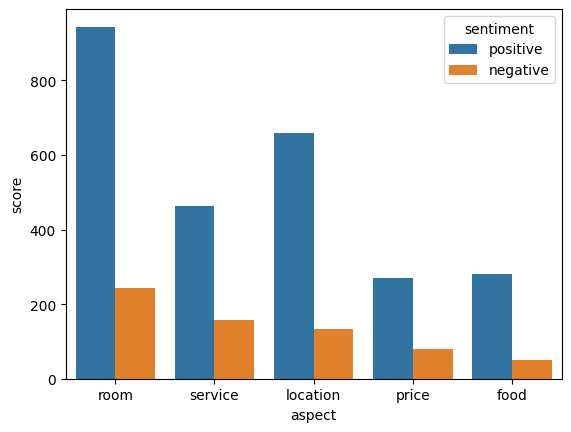

In [ ]:
aspects = ['room', 'service', 'location', 'price', 'food']
aspect_sentiment(aspects)